In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

# Dataset

In [4]:
dataset = pd.read_csv("master_lag_ml_inversed_revuf.csv")

In [5]:
print("Number of rows : {}".format(dataset.shape[0]))
print("Number of columns : {}".format(dataset.shape[1]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

Number of rows : 39516
Number of columns : 37

Display of dataset: 


,Date,code_region,Nom_region,Consommation (MW),year,month,brent_price,TIME_PERIOD,prix_kwh_elec,prix_gaz,...,rolling_mean_7,rolling_mean_15,lag_364,lag_inversed_1,lag_inversed_2,lag_inversed_3,lag_inversed_4,lag_inversed_5,lag_inversed_6,lag_inversed_7
0,2013-12-31,11,IDF,476296.0,2013,12,109.95,2013-01-01,0.1524,33.412419,...,446431.142857,467695.0,399392.0,424366.0,455574.0,450735.0,425674.0,431730.0,470656.0,466931.0
1,2014-01-01,11,IDF,424366.0,2014,1,NaN,2014-01-01,0.1585,29.812258,...,450683.571429,461028.2,492157.0,455574.0,450735.0,425674.0,431730.0,470656.0,466931.0,460424.0
2,2014-01-02,11,IDF,455574.0,2014,1,107.94,2014-01-01,0.1585,29.812258,...,450867.571429,457468.0,487111.0,450735.0,425674.0,431730.0,470656.0,466931.0,460424.0,469782.0
3,2014-01-03,11,IDF,450735.0,2014,1,106.57,2014-01-01,0.1585,29.812258,...,449652.000000,454167.8,470053.0,425674.0,431730.0,470656.0,466931.0,460424.0,469782.0,494143.0
4,2014-01-04,11,IDF,425674.0,2014,1,NaN,2014-01-01,0.1585,29.812258,...,450649.571429,448541.0,433732.0,431730.0,470656.0,466931.0,460424.0,469782.0,494143.0,454352.0


In [6]:
dataset.columns

Index(['Date', 'code_region', 'Nom_region', 'Consommation (MW)', 'year',
       'month', 'brent_price', 'TIME_PERIOD', 'prix_kwh_elec', 'prix_gaz',
       'day', 'day_of_week', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'rolling_mean_7', 'rolling_mean_15',
       'lag_364', 'lag_inversed_1', 'lag_inversed_2', 'lag_inversed_3',
       'lag_inversed_4', 'lag_inversed_5', 'lag_inversed_6', 'lag_inversed_7'],
      dtype='object')

# Train test split

In [34]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")

split_date = '2021-01-01'
train = dataset.loc[dataset['Date'] <= split_date].copy()
test = dataset.loc[dataset['Date'] > split_date].copy()

Dividing into train and test sets...


In [35]:
print("Number of rows : {}".format(test.shape[0]))
print("Number of columns : {}".format(test.shape[1]))

Number of rows : 8808
Number of columns : 37


# Features

In [36]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = [
                'Nom_region'
                ,'lag_1' 
                ,'lag_2' 
                ,'lag_3' 
                ,'lag_4' 
                ,'lag_5' 
                ,'lag_6' 
                ,'lag_7' 
                ,'lag_8','lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_364'
                , 'rolling_mean_7', 'rolling_mean_15'
                #, 'temp_max', 'temp_min', 'hours_of_sun', 'precipitation', 'windspeed' 
                #, 'prix_kwh_elec', 'prix_gaz', 'brent_price'
                , 'day', 'year', 'month', 'day_of_week'
                ]


X_train = train.loc[:,features_list]
X_test = test.loc[:,features_list]


Separating labels from features...


# Preprocessing

In [37]:
# Soit à la main : 
numeric_features = [
                'lag_1', 
                'lag_2', 
                'lag_3', 
                'lag_4', 
                'lag_5', 
                'lag_6', 
                'lag_7', 
                'lag_8','lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_364'
                , 'rolling_mean_7', 'rolling_mean_15'
                #'temp_max', 'temp_min', 'hours_of_sun', 'precipitation', 'windspeed' 
                #, 'prix_kwh_elec', 'prix_gaz', 'brent_price'
                , 'year'
                    ]
categorical_features = ['Nom_region', 'day_of_week', 'day', 'month']

In [38]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=1)),
    ('scaler', StandardScaler()) 
])

In [39]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    #('imputer', KNNImputer(n_neighbors=1)),
    ('encoder', OneHotEncoder(drop='first'))
    ])

In [40]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [41]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !!
print('...Done.')
print()

Performing preprocessings on train set...
...Done.

Performing preprocessings on test set...
...Done.



# Model

In [42]:
rfr = RandomForestRegressor(random_state=0, n_jobs=-1)

scores_df = pd.DataFrame(columns = ['Target','MAPE'])
feature_importance = pd.DataFrame(columns = ['Target','Feature','Coefficients'])

In [43]:
for i in range(1,8):
    target_variable = ['lag_inversed_' + str(i)]

    y_train = train.loc[:,target_variable]
    y_test = test.loc[:,target_variable]

    rfr.fit(X_train, y_train.values.ravel())

    y_test_pred = rfr.predict(X_test)

    scores_df = scores_df.append({
                                'Target': 'J+' + str(i),
                                'MAPE': mean_absolute_percentage_error(y_test, y_test_pred)
                                }, 
                                ignore_index = True)

    column_names = []
    for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
        if name == 'num': # if pipeline is for numeric variables
            features = features_list # just get the names of columns to which it has been applied
        else: # if pipeline is for categorical variables
            features = pipeline.named_steps['encoder'].get_feature_names_out(categorical_features) # get output columns names from OneHotEncoder
        column_names.extend(features) # concatenate features names

    feat_imp = rfr.feature_importances_.transpose()
    coefs = pd.DataFrame(data = {'Feature': column_names, 'Coefficients': abs(feat_imp)})
    coefs['Target'] = coefs.apply(lambda x: 'J+' + str(i), axis=1)
    feature_importance = feature_importance.append(coefs.sort_values(by = ['Target','Coefficients'], ascending=False).head(2))



C:\Users\elisa\AppData\Local\Temp\ipykernel_3656\1371625358.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
C:\Users\elisa\AppData\Local\Temp\ipykernel_3656\1371625358.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance = feature_importance.append(coefs.sort_values(by = ['Target','Coefficients'], ascending=False).head(2))
C:\Users\elisa\AppData\Local\Temp\ipykernel_3656\1371625358.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
C:\Users\elisa\AppData\Local\Temp\ipykernel_3656\1371625358.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature

# MAPE and Feature importance

In [44]:
scores_df['MAPE %'] = round((scores_df['MAPE']*100),2)
display(scores_df)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

In [107]:
feature_importance

,index,Target,Feature,Coefficients
0,0,J+1,rolling_mean_7,0.93527
1,1,J+1,lag_6,0.031342
2,2,J+2,rolling_mean_7,0.884826
3,3,J+2,lag_5,0.081179
4,4,J+3,lag_4,0.708393
5,5,J+3,rolling_mean_7,0.254618
6,6,J+4,lag_3,0.895162
7,7,J+4,rolling_mean_7,0.064806
8,8,J+5,lag_2,0.946425
9,9,J+5,rolling_mean_7,0.010926


In [96]:
feature_importance.reset_index(drop=True, inplace=True)
display(feature_importance)

,index,Target,Feature,Coefficients
0,0,J+1,rolling_mean_7,0.93527
1,1,J+1,lag_6,0.031342
2,2,J+2,rolling_mean_7,0.884826
3,3,J+2,lag_5,0.081179
4,4,J+3,lag_4,0.708393
5,5,J+3,rolling_mean_7,0.254618
6,6,J+4,lag_3,0.895162
7,7,J+4,rolling_mean_7,0.064806
8,8,J+5,lag_2,0.946425
9,9,J+5,rolling_mean_7,0.010926


In [97]:
#plt.figure(figsize=(25,5))
#plt.bar(scores_df.loc[:,['Target']], scores_df.loc[:,['MAPE']])
fig = px.bar(scores_df, x='Target', y='MAPE', title='% of MAPE by prediction horizon', 
            template='simple_white', width=600, height=400)
            #text=[f'{i}%' for i in scores_df['MAPE']])
fig.update_layout(title_x=0.75)

In [98]:
agg_feat = feature_importance.groupby(['Target', 'Feature'])['Coefficients'].sum().unstack().fillna(0)
agg_feat.T

Target,J+1,J+2,J+3,J+4,J+5,J+6,J+7
Feature,,,,,,,
lag_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.953053,0.000000
lag_2,0.000000,0.000000,0.000000,0.000000,0.946425,0.000000,0.000000
lag_3,0.000000,0.000000,0.000000,0.895162,0.000000,0.000000,0.000000
lag_364,0.000000,0.000000,0.000000,0.000000,0.000000,0.006183,0.000000
lag_4,0.000000,0.000000,0.708393,0.000000,0.000000,0.000000,0.000000
lag_5,0.000000,0.081179,0.000000,0.000000,0.000000,0.000000,0.000000
lag_6,0.031342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rolling_mean_15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087847
rolling_mean_7,0.935270,0.884826,0.254618,0.064806,0.010926,0.000000,0.787599


In [99]:
agg_feat

Feature,lag_1,lag_2,lag_3,lag_364,lag_4,lag_5,lag_6,rolling_mean_15,rolling_mean_7
Target,,,,,,,,,
J+1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031342,0.000000,0.935270
J+2,0.000000,0.000000,0.000000,0.000000,0.000000,0.081179,0.000000,0.000000,0.884826
J+3,0.000000,0.000000,0.000000,0.000000,0.708393,0.000000,0.000000,0.000000,0.254618
J+4,0.000000,0.000000,0.895162,0.000000,0.000000,0.000000,0.000000,0.000000,0.064806
J+5,0.000000,0.946425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010926
J+6,0.953053,0.000000,0.000000,0.006183,0.000000,0.000000,0.000000,0.000000,0.000000
J+7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087847,0.787599


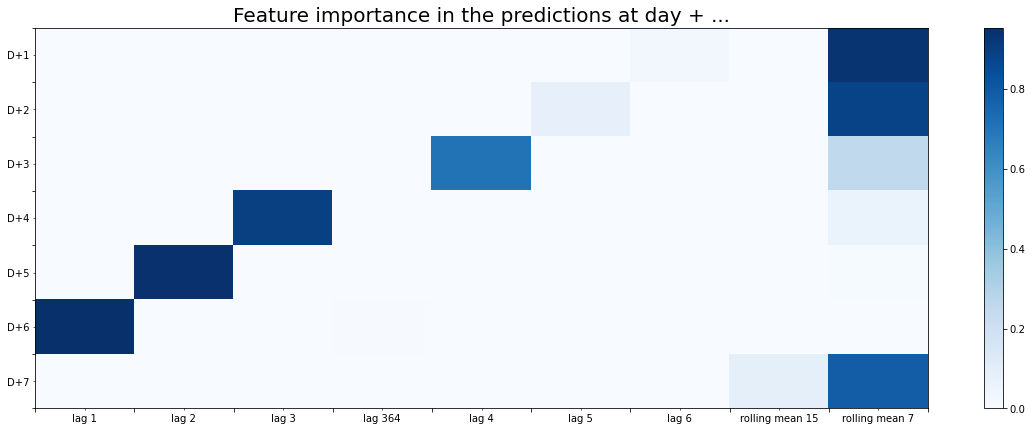

In [105]:
fig, axis = plt.subplots()

heatmap = axis.pcolor(agg_feat, cmap=plt.cm.Blues)
fig.colorbar(heatmap)

fig.set_size_inches(20, 7)

axis.set_title("Feature importance in the predictions at day + ...", size = 20)
axis.invert_yaxis()

axis.set_xticklabels('') #hide major tick labels
axis.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5, 6.5, 7.5, 8.5], minor=True)
axis.set_xticklabels(["lag 1", "lag 2", "lag 3", "lag 364", "lag 4", "lag 5", "lag 6", "rolling mean 15", "rolling mean 7"], minor = True)

axis.set_yticklabels('') #hide major tick labels
axis.set_yticks([0.5,1.5,2.5,3.5,4.5,5.5, 6.5], minor=True)
axis.set_yticklabels(["D+1", "D+2", "D+3", "D+4", "D+5", "D+6", "D+7"], minor = True)

plt.show()

In [106]:
fig = px.bar(agg_feat.iloc[0,:], orientation = 'h', title = "Feature importance J+1")
fig.update_layout(showlegend = False, 
                  margin = {'l': 120}, 
                  height = 600
                 )
fig.show()

<AxesSubplot: >

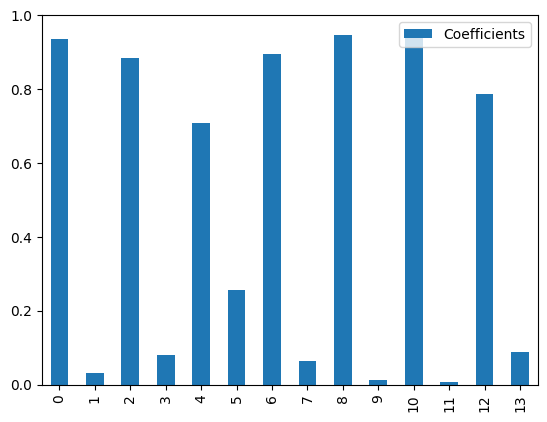

In [41]:
fig, ax = plt.subplots()
# First plot the 'Male' bars for every day.
ax.bar(feature_importance['Target'], agg_tips['Male'], label='Male')
# Then plot the 'Female' bars on top, starting at the top of the 'Male'
# bars.
ax.bar(agg_tips.index, agg_tips['Female'], bottom=agg_tips['Male'],
       label='Female')
ax.set_title('Tips by Day and Gender')
ax.legend()